In [1]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tarfile
from netCDF4 import Dataset
import os

# Define the path to the tar.gz file and the extraction directory
tar_gz_path = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\example_output.tar.gz"
extraction_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)"

# Directory containing the NetCDF files
data_surface_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\SURFACEMODEL"
data_routing_dir = r"D:\Dom_Work\A_Work\Work\01_AIT\01_NASA's Land Information System (LIS)\ROUTING"

In [4]:
import os
import xarray as xr
# Function to recursively find all .nc files in a directory
def find_nc_files(directory):
    nc_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nc'):
                nc_files.append(os.path.join(root, file))
    return nc_files

In [6]:
# Find all .nc files in each directory
surface_files = find_nc_files(data_surface_dir)
routing_files = find_nc_files(data_routing_dir)

# Check if files were found
print(f'Found {len(surface_files)} files in surfacemodel')
print(f'Found {len(routing_files)} files in routing')

# Load datasets
ds_surface = xr.open_mfdataset(surface_files, combine='by_coords')
ds_routing = xr.open_mfdataset(routing_files, combine='by_coords')

Found 15339 files in surfacemodel
Found 5113 files in routing


In [10]:
print(ds_surface)

<xarray.Dataset>
Dimensions:          (time: 5113, north_south: 36, east_west: 34,
                      SoilMoist_profiles: 4)
Coordinates:
  * time             (time) datetime64[ns] 2010-01-02 2010-01-03 ... 2024-01-01
Dimensions without coordinates: north_south, east_west, SoilMoist_profiles
Data variables:
    lat              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    lon              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    SoilMoist_tavg   (time, SoilMoist_profiles, north_south, east_west) float32 dask.array<chunksize=(1, 4, 36, 34), meta=np.ndarray>
    TWS_tavg         (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    Streamflow_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    SOIL_LAYER_THICKNE

In [12]:
print(ds_routing)

<xarray.Dataset>
Dimensions:          (time: 5113, north_south: 36, east_west: 34)
Coordinates:
  * time             (time) datetime64[ns] 2010-01-02 2010-01-03 ... 2024-01-01
Dimensions without coordinates: north_south, east_west
Data variables:
    lat              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    lon              (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
    Streamflow_tavg  (time, north_south, east_west) float32 dask.array<chunksize=(1, 36, 34), meta=np.ndarray>
Attributes: (12/15)
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         1
    SOIL_LAYER_THICKNESSES:  1.0
    title:                   LIS land surface model output
    institution:             NASA GSFC
    source:                  model_not_specified
    ...                      ...
    comment:                 website: http://lis.gsfc.nasa.gov/
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
  

In [14]:
# Data preparation for time series models

# Select specific variables (modify as needed)
data_vars = ["SoilMoist_tavg", "TWS_tavg", "Streamflow_tavg"]
surface_data = ds_surface[data_vars]

# Reshape data for time series models (reshape based on your model needs)
time_series_data = surface_data.transpose("time", "SoilMoist_profiles", "north_south", "east_west")

# Split data into training and testing sets (implement your preferred splitting method)
# Example using a simple split
split_point = int(len(time_series_data.time) * 0.8)
train_data = time_series_data.isel(time=slice(0, split_point))
test_data = time_series_data.isel(time=slice(split_point, None))

# Data preparation for CNN models (reshape based on your model needs)
# Example reshaping for 2D CNN (modify based on your model architecture)
cnn_data = surface_data.transpose("north_south", "east_west", "SoilMoist_profiles", "time")

# Remember to close the loaded dataset after processing
ds_surface.close()

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [32]:
print(list(ds_surface.variables.keys()))

['lat', 'lon', 'time', 'SoilMoist_tavg', 'TWS_tavg', 'Streamflow_tavg']


In [40]:
data_to_scale = ["SoilMoist_tavg"]
data_arrays = [ds_surface[var_name].values for var_name in data_to_scale]
print(data_array.shape)

(5113, 4, 36, 34)


In [58]:
#Data Preparation
import xarray as xr
from sklearn.preprocessing import MinMaxScaler


# Initialize scalers for the datasets
scaler_surface = MinMaxScaler()
scaler_routing = MinMaxScaler()

# Prepare surface dataset variables separately
surface_data_scaled = {}
tws_data_scaled = {}

In [86]:
# Assuming SoilMoist_tavg has an extra dimension for profiles
soil_moist_data = ds_surface['SoilMoist_tavg'].stack(grid=('north_south', 'east_west', 'SoilMoist_profiles')).values
soil_moist_data = soil_moist_data.reshape(soil_moist_data.shape[0], -1) # Reshape to 2D for scaler
print(soil_moist_data.shape)

scaler_surface.fit(soil_moist_data) # Fit and transform (similar to TWS_tavg)
soil_moist_data_scaled = scaler_surface.transform(soil_moist_data) # Transform the data
print(soil_moist_data_scaled.shape)

(5113, 4896)
(5113, 4896)


In [84]:
# Scale SoilMoist_tavg (has SoilMoist_profiles)
tws_data = ds_surface['TWS_tavg'].stack(grid=('north_south', 'east_west')).values
tws_data = tws_data.reshape(tws_data.shape[0], -1)  # Reshape to 2D for scaler
print(tws_data.shape)

scaler_surface.fit(tws_data) # Fit the scaler to the data
tws_data_scaled = scaler_surface.transform(tws_data) # Transform the data
print(tws_data_scaled.shape)

(5113, 1224)
(5113, 1224)


In [88]:
# Prepare routing dataset variables
streamflow_data_scaled = {}

# Scale Streamflow_tavg (no SoilMoist_profiles)
streamflow_data = ds_routing['Streamflow_tavg'].stack(grid=('north_south', 'east_west')).values
streamflow_data = streamflow_data.reshape(streamflow_data.shape[0], -1)  # Reshape to 2D for scaler
print(streamflow_data.shape)

scaler_routing.fit(tws_data) # Fit the scaler to the data
streamflow_data_scaled = scaler_routing.transform(streamflow_data) # Transform the data
print(streamflow_data_scaled.shape)

(5113, 1224)
(5113, 1224)


In [158]:
from tensorflow.keras.layers import Input

def create_lstm_model(data):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(data.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [166]:
# Create separate models for each dataset
model_soil_moist = create_lstm_model(soil_moist_data_scaled)
model_tws = create_lstm_model(tws_data_scaled)
model_streamflow = create_lstm_model(streamflow_data_scaled)

In [172]:
model_soil_moist.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 4896, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

In [148]:
# Split into training and testing sets
soil_moist_train_size = int(0.8 * soil_moist_data_scaled.shape[0])
soil_moist_X_train = soil_moist_data_scaled[:soil_moist_train_size, 1:]  # Exclude the first column (current TWS)
soil_moist_y_train = soil_moist_data_scaled[:soil_moist_train_size, 0]
soil_moist_X_test = soil_moist_data_scaled[soil_moist_train_size:, 1:]
soil_moist_y_test = soil_moist_data_scaled[soil_moist_train_size:, 0]

# Reshape for LSTM
soil_moist_X_train_lstm = soil_moist_X_train.reshape(soil_moist_X_train.shape[0], 1, soil_moist_X_train.shape[1])
soil_moist_X_test_lstm = soil_moist_X_test.reshape(soil_moist_X_test.shape[0], 1, soil_moist_X_test.shape[1])

In [174]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_soil_moist.fit(soil_moist_X_train, soil_moist_y_train, epochs=100, batch_size=32, 
                     validation_data=(soil_moist_X_test, soil_moist_y_test), callbacks=[early_stopping])

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 919s 7s/step - loss: 0.0427 - val_loss: 0.0199
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 970s 8s/step - loss: 0.0280 - val_loss: 0.0191
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 974s 8s/step - loss: 0.0237 - val_loss: 0.0165
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 975s 8s/step - loss: 0.0226 - val_loss: 0.0167
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 993s 8s/step - loss: 0.0230 - val_loss: 0.0168
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1186s 9s/step - loss: 0.0230 - val_loss: 0.0165
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 999s 8s/step - loss: 0.0232 - val_loss: 0.0239
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - loss: 0.0248 - val_loss: 0.0230


In [176]:
predictions = model_soil_moist.predict(soil_moist_X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


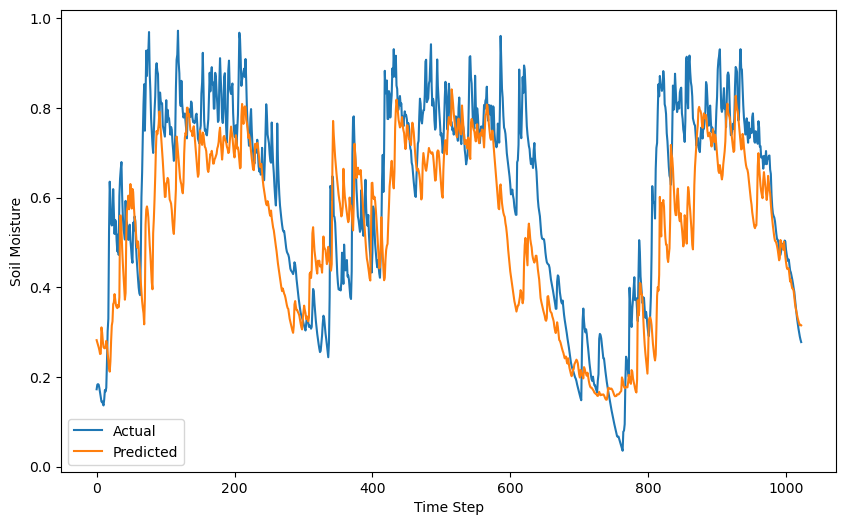

In [180]:
import matplotlib.pyplot as plt

#Plot Predictions vs. Actual Values:
plt.figure(figsize=(10, 6))
plt.plot(soil_moist_y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

In [182]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(soil_moist_y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(soil_moist_y_test, predictions)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 0.02302367
RMSE: 0.15173553
MAE: 0.117871776
